# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

[Te proporcionamos algunos comentarios para orientarte mientras completas este proyecto. Pero debes asegurarte de eliminar todos los comentarios entre corchetes antes de entregar tu proyecto.]

[Antes de sumergirte en el análisis de datos, explica por tu propia cuenta el propósito del proyecto y las acciones que planeas realizar.]

[Ten en cuenta que estudiar, modificar y analizar datos es un proceso iterativo. Es normal volver a los pasos anteriores y corregirlos/ampliarlos para permitir nuevos pasos.]

## Inicialización

In [44]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
print(plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

"usd_monthly_pay" y "usd_per_gb" son int64, mientras que los demas datos con "usd" son float, aun que el datos son tecnicamente correctos, es posible que los precios por gb cambien, y posiblemente necesite añadir centavos. La paga mensual es la misma historia, a veces se tiene que pagar con centavos incluidos.

Plan name necesita ser string

## Corregir datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [5]:
# Cambiar las columnas a tipo float
plans['usd_monthly_pay'] = plans['usd_monthly_pay'].astype(float)
plans['usd_per_gb'] = plans['usd_per_gb'].astype(float)
plans['plan_name'] = plans['plan_name'].astype('string')

## Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [6]:
plans['usd_per_gb_ratio'] = plans['usd_per_gb'] / (plans['mb_per_month_included'] / 1024)
plans['expected_minutes'] = plans['minutes_included'] * (plans['usd_monthly_pay'] / plans['usd_per_minute'])
plans['expected_data_usage'] = (plans['mb_per_month_included'] / 1024) * (plans['usd_monthly_pay'] / plans['usd_per_gb'])
plans.info()
print(plans.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      float64
 4   usd_per_gb             2 non-null      float64
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      string 
 8   usd_per_gb_ratio       2 non-null      float64
 9   expected_minutes       2 non-null      float64
 10  expected_data_usage    2 non-null      float64
dtypes: float64(7), int64(3), string(1)
memory usage: 304.0 bytes
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000       

## Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Imprime una muestra de datos para usuarios

print(users.head(10).drop_duplicates())

   user_id first_name  last_name  age                                    city  \
0     1000   Anamaria      Bauer   45   Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28         Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36    Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                           Tulsa, OK MSA   
4     1004    Leonila   Thompson   40         Seattle-Tacoma-Bellevue, WA MSA   
5     1005      Livia    Shields   31     Dallas-Fort Worth-Arlington, TX MSA   
6     1006     Jesusa   Bradford   73  San Francisco-Oakland-Berkeley, CA MSA   
7     1007    Eusebio      Welch   42           Grand Rapids-Kentwood, MI MSA   
8     1008      Emely    Hoffman   53       Orlando-Kissimmee-Sanford, FL MSA   
9     1009      Gerry     Little   19  San Jose-Sunnyvale-Santa Clara, CA MSA   

     reg_date      plan  churn_date  
0  2018-12-24  ultimate         NaN  
1  2018-08-13      surf         

[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

 User id esta correcto. First name, Last name, City y Plan necesita ser String. Reg date y churn date necesitan ser fechas.
 Esos son todos los problemas claros a plena vista

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [9]:
# Convertir las columnas a tipo string
users['first_name'] = users['first_name'].astype('string')
users['last_name'] = users['last_name'].astype('string')
users['city'] = users['city'].astype('string')
users['plan'] = users['plan'].astype('string')

# Convertir las columnas de fecha a tipo datetime
users['reg_date'] = pd.to_datetime(users['reg_date'], errors='coerce')
users['churn_date'] = pd.to_datetime(users['churn_date'], errors='coerce')

# Verificar los cambios
users.info()
print(users.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    string        
 2   last_name   500 non-null    string        
 3   age         500 non-null    int64         
 4   city        500 non-null    string        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    string        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), string(4)
memory usage: 31.4 KB
   user_id first_name  last_name  age                                    city  \
0     1000   Anamaria      Bauer   45   Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28         Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36    Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo  

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [10]:
# 1. Segmentación por edad
bins = [0, 30, 60, np.inf]
labels = ['Joven', 'Adulto', 'Senior']
users['age_group'] = pd.cut(users['age'], bins=bins, labels=labels, right=False)

# Verificar los cambios
print(users.head(10))

   user_id first_name  last_name  age                                    city  \
0     1000   Anamaria      Bauer   45   Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28         Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36    Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                           Tulsa, OK MSA   
4     1004    Leonila   Thompson   40         Seattle-Tacoma-Bellevue, WA MSA   
5     1005      Livia    Shields   31     Dallas-Fort Worth-Arlington, TX MSA   
6     1006     Jesusa   Bradford   73  San Francisco-Oakland-Berkeley, CA MSA   
7     1007    Eusebio      Welch   42           Grand Rapids-Kentwood, MI MSA   
8     1008      Emely    Hoffman   53       Orlando-Kissimmee-Sanford, FL MSA   
9     1009      Gerry     Little   19  San Jose-Sunnyvale-Santa Clara, CA MSA   

    reg_date      plan churn_date age_group  
0 2018-12-24  ultimate        NaT    Adulto  
1 2018-08-13    

## Llamadas

In [11]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
# Imprime una muestra de datos para las llamadas
print(calls.head(10))

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22
5  1000_388     1000  2018-12-31      2.20
6  1000_510     1000  2018-12-27      5.75
7  1000_521     1000  2018-12-28     14.18
8  1000_530     1000  2018-12-28      5.77
9  1000_544     1000  2018-12-26      4.40


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

ID tiene un formato redundante, si el User id es el ID del usuario, el ID debe ser el id de la llamada, por lo que se necesita quitar el id del usuario del id.
 
 Call date necesita ser fecha

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [13]:
# Eliminar la parte 'xxxx_' de la columna 'id' (donde 'x' es un número) y cambiar a integer
calls['id'] = calls['id'].str.replace(r'^\d+_', '', regex=True)

#cambiar los tipos de datos
calls['id'] = calls['id'].astype(int)
calls['call_date'] = pd.to_datetime(calls['call_date'], errors='coerce')

calls.info()
print()
print(calls.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  int64         
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 4.2 MB

    id  user_id  call_date  duration
0   93     1000 2018-12-27      8.52
1  145     1000 2018-12-27     13.66
2  247     1000 2018-12-27     14.48
3  309     1000 2018-12-28      5.76
4  380     1000 2018-12-30      4.22


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

No hay mucha informacion sobre una llamada que valga a pena añadir...

## Mensajes

In [14]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [15]:
# Imprime una muestra de datos para los mensajes
print(messages.head())

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

ID tiene el mismo problema que calls tenia, el ID del usuario esta siendo añadida al inicio de su formato, haciendolo redundante.

ID necesita ser Int, y message date necesita ser Date

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [16]:
# Eliminar la parte 'xxxx_' de la columna 'id' (donde 'x' es un número) y cambiar a integer
messages['id'] = messages['id'].str.replace(r'^\d+_', '', regex=True)

# Cambiar los tipos de datos
messages['id'] = messages['id'].astype(int)
messages['message_date'] = pd.to_datetime(messages['message_date'], errors='coerce')

# Mostrar la información y los primeros registros
messages.info()
print()
print(messages.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  int64         
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.7 MB

    id  user_id message_date
0  125     1000   2018-12-27
1  160     1000   2018-12-31
2  223     1000   2018-12-31
3  251     1000   2018-12-27
4  255     1000   2018-12-26


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

No hay mas informacion sobre mensajes que valga la pena añadir (a no ser que la longitud del mensaje le sea util a alguien).

## Internet

In [17]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [18]:
# Imprime una muestra de datos para el tráfico de internet
print(internet.head())

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

ID comparte el mismo problema, tiene la id del usuario incluido.

ID necesita ser int y Session date necesita ser Datetime.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [19]:
# Eliminar la parte 'xxxx_' de la columna 'id' (donde 'x' es un número) y cambiar a integer
internet['id'] = internet['id'].str.replace(r'^\d+_', '', regex=True)

# Cambiar los tipos de datos
internet['id'] = internet['id'].astype(int)
internet['session_date'] = pd.to_datetime(internet['session_date'], errors='coerce')

# Mostrar la información y los primeros registros
internet.info()
print()
print(internet.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  int64         
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.2 MB

    id  user_id session_date  mb_used
0   13     1000   2018-12-29    89.86
1  204     1000   2018-12-31     0.00
2  379     1000   2018-12-28   660.40
3  413     1000   2018-12-26   270.99
4  442     1000   2018-12-27   880.22


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

No hay datos relevantes al trabajo que se puedan añadir, aunque si puede haber mucha informacion que se puede sacar en esta area, no es importante para el objetivo del projecto que es "saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad."

## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [20]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
plans.info()
print()
print(plans.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      float64
 4   usd_per_gb             2 non-null      float64
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      string 
 8   usd_per_gb_ratio       2 non-null      float64
 9   expected_minutes       2 non-null      float64
 10  expected_data_usage    2 non-null      float64
dtypes: float64(7), int64(3), string(1)
memory usage: 304.0 bytes

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000      

## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [21]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
# Extraer el mes y el año de la fecha de la llamada
calls['month_year'] = calls['call_date'].dt.to_period('M')

# Contar el número de llamadas por usuario y por mes
calls_per_user_month = calls.groupby(['user_id', 'month_year']).size().reset_index(name='num_calls')

In [22]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
# Extraer el mes y el año de la fecha de la llamada
calls['month_year'] = calls['call_date'].dt.to_period('M')

# Calcular el total de minutos usados por cada usuario al mes
minutes_per_user_month = calls.groupby(['user_id', 'month_year'])['duration'].sum().reset_index(name='total_minutes')

print(calls_per_user_month.head())

   user_id month_year  num_calls
0     1000    2018-12         16
1     1001    2018-08         27
2     1001    2018-09         49
3     1001    2018-10         65
4     1001    2018-11         64


In [23]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
# Extraer el mes y el año de la fecha del mensaje
messages['month_year'] = messages['message_date'].dt.to_period('M')

# Calcular el número de mensajes enviados por cada usuario al mes
messages_per_user_month = messages.groupby(['user_id', 'month_year'])['id'].count().reset_index(name='total_messages')

In [24]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
# Extraer el mes y el año de la fecha de la sesión de Internet
internet['month_year'] = internet['session_date'].dt.to_period('M')

# Calcular el volumen de tráfico de Internet usado por cada usuario al mes
internet_traffic_per_user_month = internet.groupby(['user_id', 'month_year'])['mb_used'].sum().reset_index(name='total_traffic_mb')

[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [25]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

# Realizar las fusiones entre los DataFrames de llamadas, minutos, mensajes e Internet
merged_data = calls_per_user_month \
    .merge(minutes_per_user_month, on=['user_id', 'month_year'], how='left') \
    .merge(messages_per_user_month, on=['user_id', 'month_year'], how='left') \
    .merge(internet_traffic_per_user_month, on=['user_id', 'month_year'], how='left') \
    .merge(users, on='user_id', how='left')


# Mostrar el resultado de la fusión
print(merged_data)

      user_id month_year  num_calls  total_minutes  total_messages  \
0        1000    2018-12         16         116.83            11.0   
1        1001    2018-08         27         171.14            30.0   
2        1001    2018-09         49         297.69            44.0   
3        1001    2018-10         65         374.11            53.0   
4        1001    2018-11         64         404.59            36.0   
...       ...        ...        ...            ...             ...   
2253     1498    2018-12         39         324.77             NaN   
2254     1499    2018-09         41         330.37             NaN   
2255     1499    2018-10         53         363.28             NaN   
2256     1499    2018-11         45         288.56             NaN   
2257     1499    2018-12         65         468.10             NaN   

      total_traffic_mb first_name   last_name  age  \
0              1901.47   Anamaria       Bauer   45   
1              6919.15     Mickey   Wilkerson   28 

In [26]:
# Añade la información de la tarifa

# Fusiona los datos de consumo con la información de la tarifa usando 'merged_data'
#pd.merge(left, right, how='inner', on=None, left_on=None, right_on=None, left_index=False, 
#right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)
df_rev = pd.merge(
    merged_data,  # Usa el DataFrame fusionado previamente con los datos de consumo por usuario
    plans,  # Selecciona las columnas necesarias de planes
    how='left',  # 'left' para mantener todos los usuarios del DataFrame original
    left_on='plan',    # columna en merged_data
    right_on='plan_name'  # columna en plans
)
df_rev = df_rev.drop(columns=['plan_name'])

# Revisa las primeras filas para verificar la correcta fusión
print(df_rev.head())

   user_id month_year  num_calls  total_minutes  total_messages  \
0     1000    2018-12         16         116.83            11.0   
1     1001    2018-08         27         171.14            30.0   
2     1001    2018-09         49         297.69            44.0   
3     1001    2018-10         65         374.11            53.0   
4     1001    2018-11         64         404.59            36.0   

   total_traffic_mb first_name  last_name  age  \
0           1901.47   Anamaria      Bauer   45   
1           6919.15     Mickey  Wilkerson   28   
2          13314.82     Mickey  Wilkerson   28   
3          22330.49     Mickey  Wilkerson   28   
4          18504.30     Mickey  Wilkerson   28   

                                    city  ... messages_included  \
0  Atlanta-Sandy Springs-Roswell, GA MSA  ...              1000   
1        Seattle-Tacoma-Bellevue, WA MSA  ...                50   
2        Seattle-Tacoma-Bellevue, WA MSA  ...                50   
3        Seattle-Tacoma-Bell

[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [27]:
# Calcula el ingreso mensual para cada usuario
# Primero convierte tráfico de MB a GB
df_rev['total_traffic_gb'] = df_rev['total_traffic_mb'] / 1024

# Función para calcular el ingreso mensual
def calculate_monthly_revenue(row):
    # Cargos extra (no pueden ser negativos)
    extra_minutes = max(0, row['total_minutes'] - row['minutes_included'])
    extra_messages = max(0, row['total_messages'] - row['messages_included'])
    extra_gb = max(0, row['total_traffic_gb'] - (row['mb_per_month_included'] / 1024))  # porque el límite está en MB

    # Costos extra
    cost_extra_minutes = extra_minutes * row['usd_per_minute']
    cost_extra_messages = extra_messages * row['usd_per_message']
    cost_extra_gb = extra_gb * row['usd_per_gb']

    # Total = renta mensual + cargos extra
    total_revenue = row['usd_monthly_pay'] + cost_extra_minutes + cost_extra_messages + cost_extra_gb

    return total_revenue

# Aplica la función
df_rev['monthly_revenue'] = df_rev.apply(calculate_monthly_revenue, axis=1)

# Agrupa por usuario y mes, y toma el máximo (porque los datos duplicados deberían tener el mismo revenue)
df_final_revenue = df_rev.groupby(['user_id', 'month_year', 'plan'], as_index=False).agg({
    'monthly_revenue': 'max'
})

# Visualiza
print(df_final_revenue.head())

   user_id month_year      plan  monthly_revenue
0     1000    2018-12  ultimate        70.000000
1     1001    2018-08      surf        20.000000
2     1001    2018-09      surf        20.000000
3     1001    2018-10      surf        88.161191
4     1001    2018-11      surf        50.706055


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

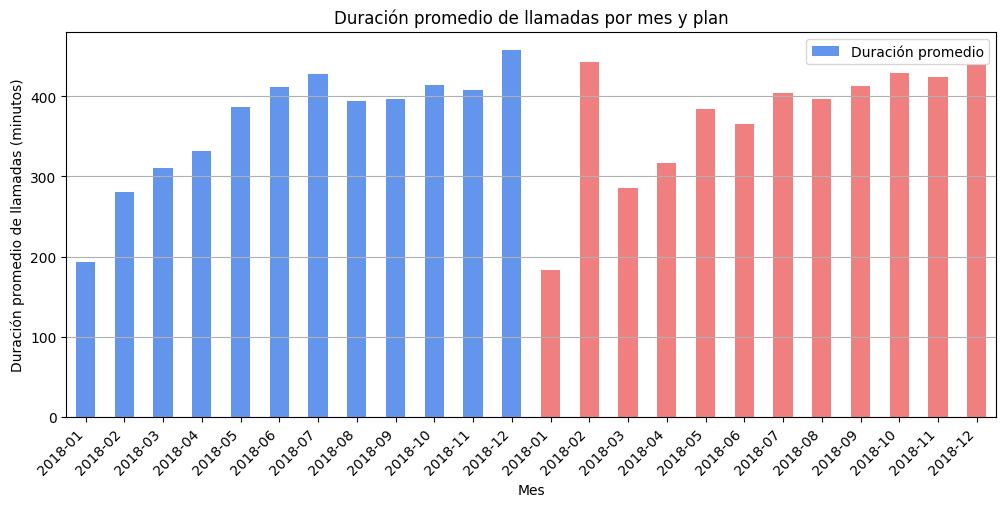

In [28]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
# Agrupa por plan y mes, y calcula la duración promedio de llamadas
avg_call_duration = df_rev.groupby(['plan', 'month_year'])['total_minutes'].mean().reset_index()

# Gráfico de barras
avg_call_duration.plot(
    kind='bar',
    x='month_year',
    y='total_minutes',
    title='Duración promedio de llamadas por mes y plan',
    xlabel='Mes',
    ylabel='Duración promedio de llamadas (minutos)',
    color=['cornflowerblue' if p == 'surf' else 'lightcoral' for p in avg_call_duration['plan']],
    figsize=(12,5)
)

plt.xticks(rotation=45, ha='right')
plt.legend(['Duración promedio'])
plt.grid(axis='y')
plt.show()


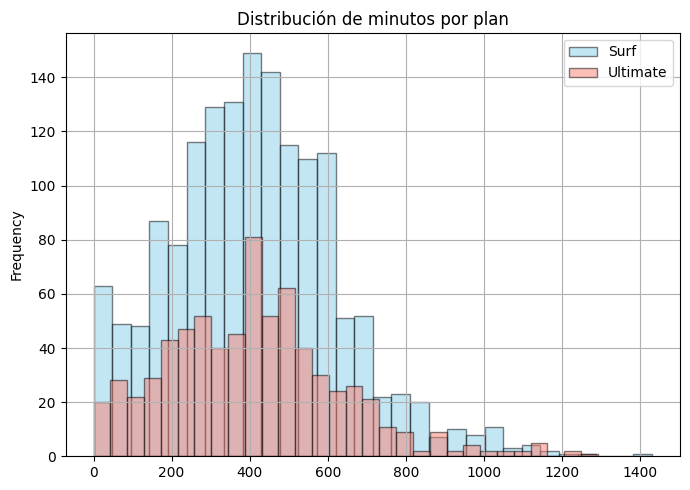

In [29]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
df_rev[df_rev['plan'] == 'surf']['total_minutes'].plot(
    kind='hist',
    bins=30,
    alpha=0.5,
    color='skyblue',
    edgecolor='black',
    label='Surf',
    figsize=(7,5),
    title='Distribución de minutos por plan'
)

df_rev[df_rev['plan'] == 'ultimate']['total_minutes'].plot(
    kind='hist',
    bins=30,
    alpha=0.5,
    color='salmon',
    edgecolor='black',
    label='Ultimate'
)
plt.xlabel='Minutos'
plt.ylabel='Usuarios'
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [30]:
# Calcula la media y la varianza de la duración mensual de llamadas.
duracion_llamadas = df_rev.groupby('plan')['total_minutes'].agg(['mean', 'var'])

# Muestra los resultados
print(duracion_llamadas)

                mean           var
plan                              
surf      412.097890  47001.254231
ultimate  410.180954  50510.631705


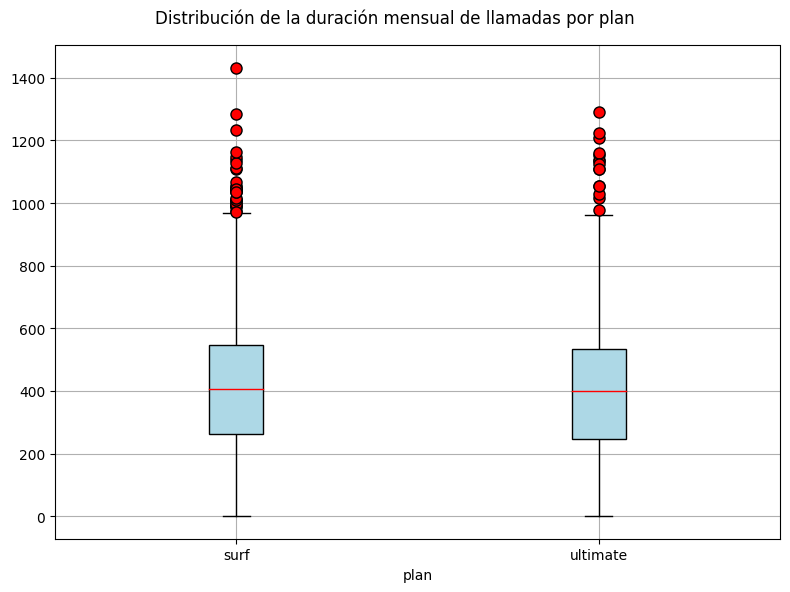

In [31]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
df_rev.boxplot(
    column='total_minutes',
    by='plan',
    grid=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='black'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    flierprops=dict(markerfacecolor='red', marker='o', markersize=8),
    figsize=(8,6)
)

plt.suptitle('Distribución de la duración mensual de llamadas por plan')
plt.title('')
plt.tight_layout()
plt.show()

[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a las llamadas. ¿Su comportamiento varía en función del plan?]

El comportamiento cambia levemente dependiendo del plan, si. No obstante, la version Surf suele se el plan mas popular en el inicio del año, pero el Ultimate obtiene traccion a finales del año. Pero la gente siempre habla mas mientras usan el plan de Surf.

### Mensajes

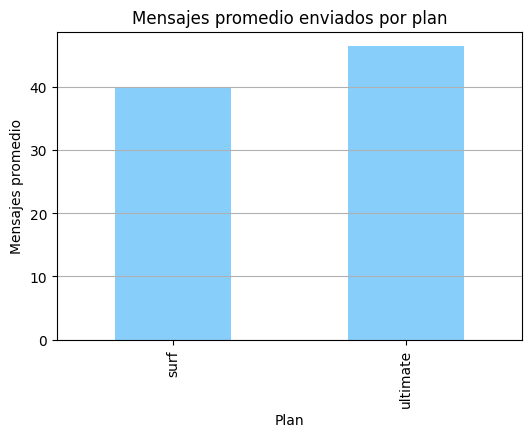

In [32]:
# Gráfico de barras de mensajes promedio por plan:
df_rev.groupby('plan')['total_messages'].mean().plot(
    kind='bar',
    title='Mensajes promedio enviados por plan',
    xlabel='Plan',
    ylabel='Mensajes promedio',
    color='lightskyblue',
    figsize=(6,4)
)
plt.grid(axis='y')
plt.show()

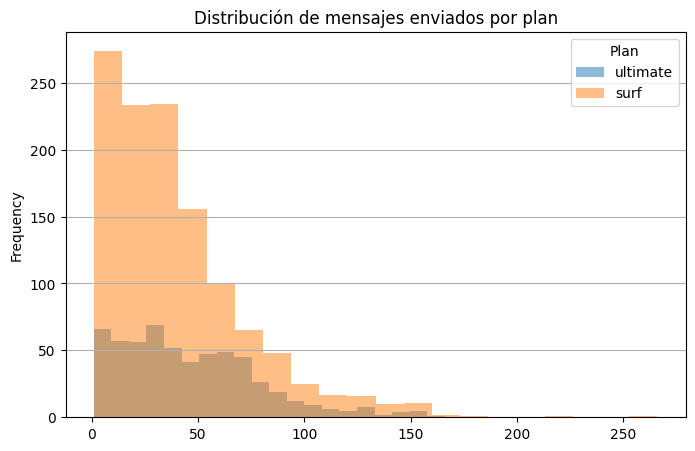

In [33]:
# Histograma del número de mensajes enviados:
for plan in df_rev['plan'].unique():
    df_rev[df_rev['plan'] == plan]['total_messages'].plot(
        kind='hist',
        bins=20,
        alpha=0.5,
        label=plan,
        figsize=(8,5),
        xlabel='Número de mensajes',
        ylabel='Número de usuarios'
    )

plt.title('Distribución de mensajes enviados por plan')

plt.legend(title='Plan')
plt.grid(axis='y')
plt.show()

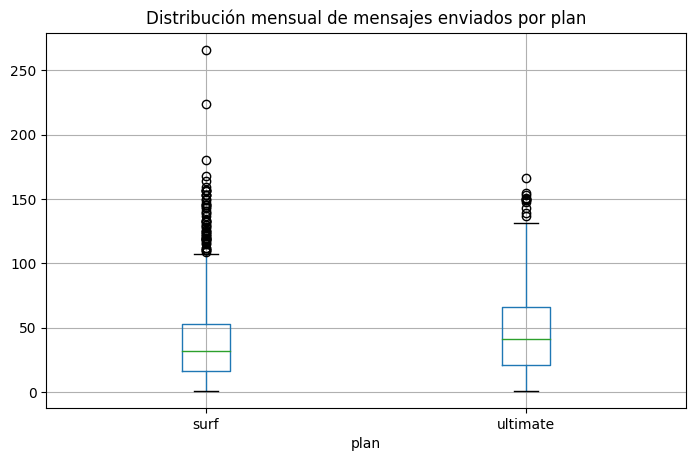

In [34]:
# Diagrama de caja de mensajes enviados por plan:
df_rev.boxplot(
    column='total_messages',
    by='plan',
    grid=True,
    figsize=(8,5)
)
plt.title('Distribución mensual de mensajes enviados por plan')
plt.suptitle('')  # Quita el título automático "Boxplot grouped by plan"
plt.show()

[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a los mensajes. ¿Su comportamiento varía en función del plan?]

Los usuarios envian mas mensajes en Ultimate que surf, pero no es lo suficientemente notable, ambos clientes usan internet en en similares cantidades. Hay much agente que prefiere usar Ultimate para enviar mensajes.

### Internet

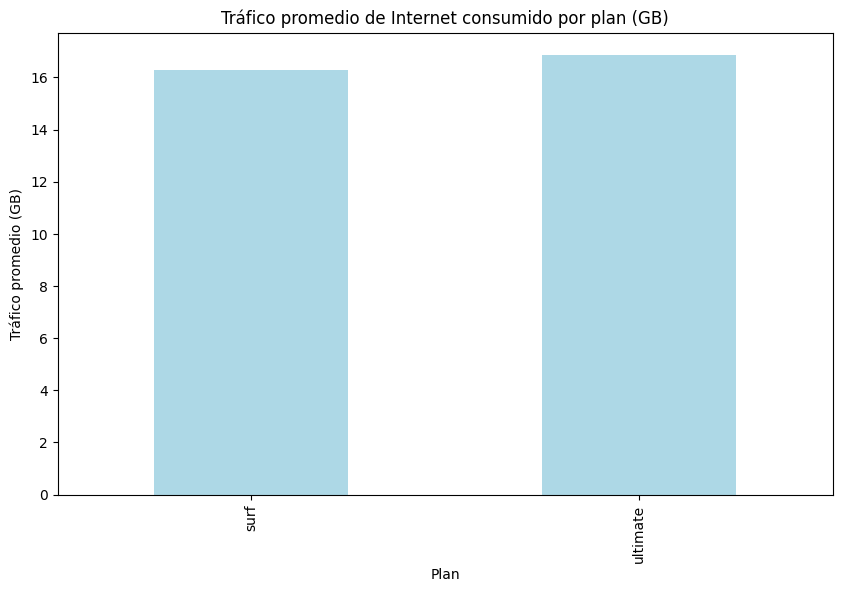

In [35]:
# Compara la duración promedio de sessiones por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
# Convertir el tráfico de Internet de MB a GB
df_rev['total_traffic_gb'] = df_rev['total_traffic_mb'] / 1024

# Crear un gráfico de barras para comparar el tráfico promedio de Internet consumido por plan en GB
df_rev.groupby('plan')['total_traffic_gb'].mean().plot(
    kind='bar',
    title='Tráfico promedio de Internet consumido por plan (GB)',
    xlabel='Plan',
    ylabel='Tráfico promedio (GB)',
    color='lightblue',
    figsize=(10,6)
)

# Muestra el gráfico
plt.show()

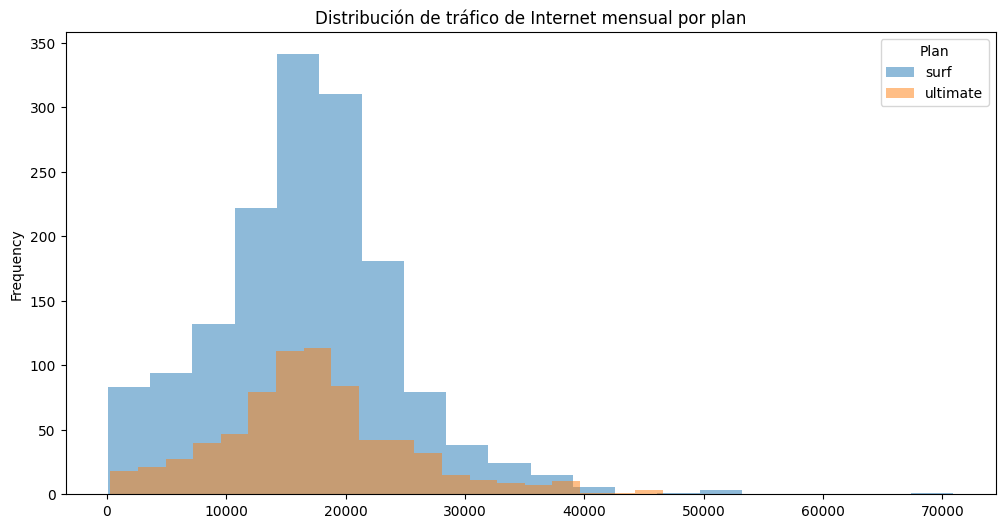

In [36]:
# Compara el número de mb mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# Histograma de la cantidad de tráfico de Internet (en MB) por plan
# Asegúrate de importar matplotlib

# Histograma de la cantidad de tráfico de Internet (en MB) por plan
df_rev.groupby('plan')['total_traffic_mb'].plot(
    kind='hist', 
    bins=20, 
    alpha=0.5, 
    figsize=(12, 6),
    title='Distribución de tráfico de Internet mensual por plan',
    legend=True
)

# Personalizar el gráfico
plt.legend(title='Plan')
plt.show()


<Figure size 600x500 with 0 Axes>

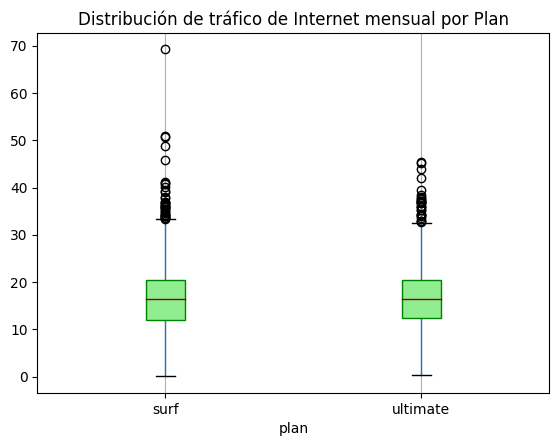

In [37]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de internet
# Crear una figura
plt.figure(figsize=(6,5))


# Diagrama de caja usando el 'plan' del usuario
df_rev.boxplot(
    column='total_traffic_gb',
    by='plan',  # usa el plan del usuario directamente
    patch_artist=True,
    boxprops=dict(facecolor='lightgreen', color='green'),
    medianprops=dict(color='darkred')
)

# Personalización
plt.title('Distribución de tráfico de Internet mensual por Plan')
plt.suptitle('')  # Quita el título automático extra de pandas
plt.grid(axis='y')

# Mostrar
plt.show()


[Elabora las conclusiones sobre cómo los usuarios tienden a consumir el tráfico de Internet. ¿Su comportamiento varía en función del plan?]

Debido a que mas gente usa el surf, entonces hay mas trafico y distribuidores en interner, pero tanto el surf como ultimate, ambos usan el mismo promedio de tiempo de internett sin importar el paquete.

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

In [38]:
# Agrupar por plan y calcular estadísticas descriptivas sobre los ingresos
ingresos = df_rev.groupby('plan')['monthly_revenue'].agg(['mean', 'var', 'std', 'min', 'max'])

# Mostrar estadísticas
print(ingresos)

               mean          var        std   min         max
plan                                                         
surf      56.696270  2686.179784  51.828369  20.0  581.328509
ultimate  72.079233   114.936364  10.720838  70.0  178.522764


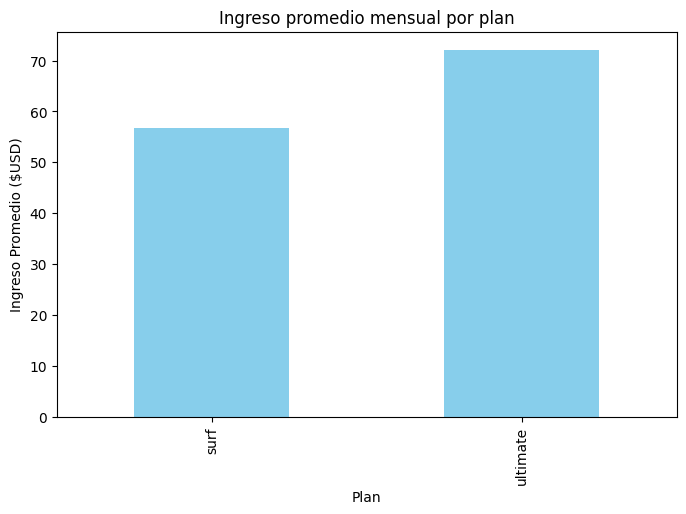

In [39]:
# Gráfico de barras para visualizar la media de ingresos por plan
ingresos['mean'].plot(
    kind='bar',
    title='Ingreso promedio mensual por plan',
    color='skyblue',
    figsize=(8,5),
    xlabel='Plan',
    ylabel='Ingreso Promedio ($USD)'
)
plt.show()

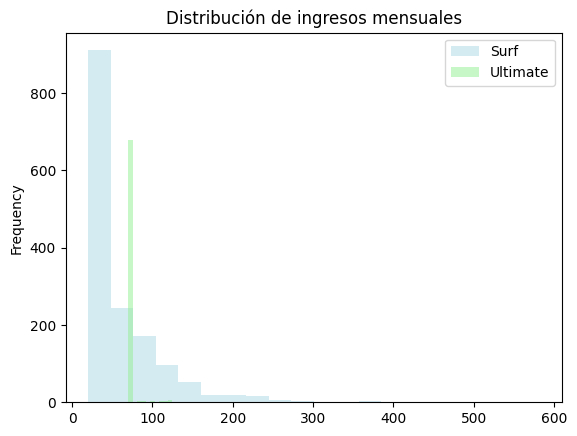

In [40]:
# Histograma para la distribución de ingresos mensuales
df_rev[df_rev['plan'] == 'surf']['monthly_revenue'].plot(
    kind='hist',
    bins=20,
    alpha=0.5,
    title='Distribución de ingresos mensuales',
    color='lightblue',
    xlabel='Ingreso mensual ($USD)',
    ylabel='Frecuencia'
)
df_rev[df_rev['plan'] == 'ultimate']['monthly_revenue'].plot(
    kind='hist',
    bins=20,
    alpha=0.5,
    color='lightgreen'
)

plt.legend(['Surf', 'Ultimate'])
plt.show()

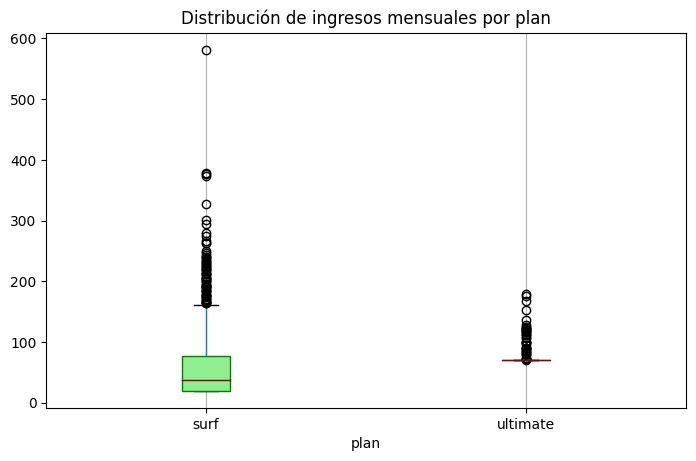

In [41]:
# Diagrama de caja para mostrar la distribución de los ingresos por plan
df_rev.boxplot(
    column='monthly_revenue',
    by='plan',
    patch_artist=True,
    boxprops=dict(facecolor='lightgreen', color='green'),
    medianprops=dict(color='darkred'),
    figsize=(8,5)
)

plt.title('Distribución de ingresos mensuales por plan')
plt.suptitle('')
plt.grid(axis='y')
plt.show()

[Elabora las conclusiones sobre cómo difiere el ingreso entre los planes.]

Los ingresos promedios generados por el plan Ultimate es mucho mejor que el surf, no obstante, mucha gente sigue usando Surf, por lo que la distribucion de ingresos sigue siendo mas consistente en Surf.

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [42]:
# Prueba las hipótesis

# Filtramos los ingresos por plan
ingresos_ultimate = df_rev[df_rev['plan'] == 'ultimate']['monthly_revenue']
ingresos_surf = df_rev[df_rev['plan'] == 'surf']['monthly_revenue']

# Realizamos la prueba t para comparar las medias de los ingresos entre los dos planes
t_stat, p_value = st.ttest_ind(ingresos_ultimate, ingresos_surf)

# Establecemos el nivel de significancia
alpha = 0.05

# Mostramos los resultados
print(f'Estadístico t: {t_stat}')
print(f'Valor p: {p_value}')

# Tomamos una decisión basada en el valor p
if p_value < alpha:
    print('Rechazamos la hipótesis nula: Los ingresos promedio de los planes son diferentes.')
else:
    print('No rechazamos la hipótesis nula: No hay evidencia suficiente para afirmar que los ingresos promedio de los planes son diferentes.')


Estadístico t: 7.8473407496724725
Valor p: 6.507216631144257e-15
Rechazamos la hipótesis nula: Los ingresos promedio de los planes son diferentes.


[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [45]:
# Prueba las hipótesis
# Crear una columna 'region' basada en la ciudad para identificar a los usuarios de NY-NJ
df_rev['region'] = df_rev['city'].apply(lambda x: 'NY-NJ' if 'New York-Newark-Jersey City' in x else 'Other')

# Filtrar los ingresos de los usuarios en NY-NJ y de otras regiones
ingresos_ny_nj = df_rev[df_rev['region'] == 'NY-NJ']['monthly_revenue']
ingresos_otras_regiones = df_rev[df_rev['region'] == 'Other']['monthly_revenue']

# Prueba t para muestras independientes
t_stat, p_val = st.ttest_ind(ingresos_ny_nj, ingresos_otras_regiones)

# Imprimir los resultados
print(f'T-Statistic: {t_stat}')
print(f'P-Value: {p_val}')

# Establecer el valor alfa
alpha = 0.05

# Evaluar la hipótesis
if p_val < alpha:
    print("Rechazamos la hipótesis nula: Los ingresos promedio son diferentes entre NY-NJ y otras regiones.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para decir que los ingresos promedio son diferentes.")

T-Statistic: -2.602499070146906
P-Value: 0.009315292754890996
Rechazamos la hipótesis nula: Los ingresos promedio son diferentes entre NY-NJ y otras regiones.


## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]

El plan que se deberia promosionar mas es el Surf, debido a que es el mas popular con la gente, especialmente en los inicios de año, y solo ofrecer el Ultimate a clientes que esten interesados a mejorar el plan actual.

Mas clientes prefieren llamar con el PLan Surf que Ultimate, pero Los clientes prefieren mandar mas mensajes con el plan Ultimate.

Los clientes usan el internet la misma cantidad de tiempo, los planes no cambian cuanto tiempo lo usan, pero la cantidad de clientes usando Surf para llamadas si cambian cuanta gente usa el internet del plan Surf.

Aunque los clientes generan mas ingresos si compran el plan Ultimate, son muchas mas personas que usan Surf como la opcion mas economica, por lo que las ganancias son mas por el Surf, el area geologica no cambia este hecho.